In [2]:
import torch.nn as nn
import sys
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# For drive
path = "/content/drive/My Drive/project/"

sys.path.append(path + "URP")
sys.path.append(path + "URP/learning")
sys.path.append(path + "URP/data")
sys.path.append(path + "URP/models")
sys.path.append(path + "URP/forgetting")

In [ ]:
# For PC
path = ".."
sys.path.append(path)
sys.path.append(path + "/learning")
sys.path.append(path + "/data")
sys.path.append(path + "/models")
sys.path.append(path + "/forgetting")

In [5]:
from data_utils import show_random, AddNoise, remove_random, remove_class, combine_datasets
from data import get_dataset, dummy_clusters, dummy_half_doughnuts
from models_utils import *
import models
from learn import *
from forget import *
from utils import set_seed

In [6]:
set_seed()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

SEED SET TO:  13


device(type='cuda', index=0)

In [7]:
cifar10_train, cifar10_val, cifar10_test = get_dataset("cifar10", batch_size=32, cuda=0,
                  train_size=50000, val_size=40000, test_size=5000,
                  test_batch_size=10)
len(cifar10_train)

Files already downloaded and verified
Dataset sizes: 	 train: 50000 	 val: 40000 	 test: 5000
Batch size: 	 32


1563

In [ ]:
mnist_train, mnist_val, mnist_test = get_dataset("mnist", batch_size=16, cuda=0,
                  train_size=10000, val_size=1000, test_size=500,
                  test_batch_size=10)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw

Dataset sizes: 	 train: 10000 	 val: 1000 	 test: 500
Batch size: 	 16


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
cnn = {"filters_percentage": 1, "n_channels":3,"num_classes": 50, "dropout": True, "batch_norm": True}
cnn_model = get_model("cnn", **cnn)
print(cnn_model.__class__.__name__)

CNN


In [ ]:
dnn = {"input_size": 1024, "hidden_size":32, "num_classes":10,"num_layer": 6, "activation": nn.ReLU()}
dnn_model = get_model("mlp", **dnn)
print(dnn_model.__class__.__name__)

MLP


In [9]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{60}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{dnn_model.__class__.__name__}_{70}.pth.tar")
dnn_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [10]:
test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=cifar10_test, at_epoch=None)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.2861577272415161
Error:  0.30000001192092896
FINISHED TESTING


CNN(
  (features): Sequential(
    (0): ConvUnit(
      (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvUnit(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvUnit(
      (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Dropout(p=0.5, inplace=True)
    (4): ConvUnit(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (5): ConvUnit(
      (0): Conv2

In [ ]:
test(model=dnn_model, loss='ce', lossfn=None, optimizer='sgd', device=device, dataset='mnist', test_loader=mnist_test, at_epoch=None)

Optimizer: 	  sgd

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.1280597597360611
Error:  0.0
FINISHED TESTING


MLP(
  (activation): ReLU()
  (layers): Sequential(
    (0): Layer(in_features=1024, out_features=32, bias=True, beta=0.31622776601683794)
    (1): ReLU()
    (2): Layer(in_features=32, out_features=32, bias=True, beta=0.31622776601683794)
    (3): ReLU()
    (4): Layer(in_features=32, out_features=32, bias=True, beta=0.31622776601683794)
    (5): ReLU()
    (6): Layer(in_features=32, out_features=32, bias=True, beta=0.31622776601683794)
    (7): ReLU()
    (8): Layer(in_features=32, out_features=32, bias=True, beta=0.31622776601683794)
    (9): ReLU()
    (10): Layer(in_features=32, out_features=10, bias=True, beta=0.31622776601683794)
  )
)

In [15]:
forget, retain = remove_class(cifar10_test, [0])
len(forget), len(retain)

(48, 453)

In [ ]:
neg_gradient(dnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset="mnist", lossfn=None, train_loader=forget, val_loader=retain,
    scheduler=None, weight_decay=0.0, lr=0.01, momentum=0)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in MLP_training]
[0] train metrics:{"loss": 0.0, "error": 0.0}
[0] test metrics:{"loss": 123.75914764404297, "error": 0.9285714253783226}
Epoch number: 0 :
 Epoch Time: 0.91 sec
[1] train metrics:{"loss": 0.0, "error": 0.0}
[1] test metrics:{"loss": 123.75914764404297, "error": 0.9285714253783226}
Epoch number: 1 :
 Epoch Time: 0.85 sec
[2] train metrics:{"loss": 0.0, "error": 0.0}
[2] test metrics:{"loss": 123.75914764404297, "error": 0.9285714253783226}
Epoch number: 2 :
 Epoch Time: 0.82 sec
[3] train metrics:{"loss": 0.0, "error": 0.0}
[3] test metrics:{"loss": 123.75914764404297, "error": 0.9285714253783226}
Epoch number: 3 :
 Epoch Time: 0.88 sec
[4] train metrics:{"loss": 0.0, "error": 0.0}
[4] test metrics:{"loss": 123.75914764404297, "error": 0.9285714253783226}
Epoch number: 4 :
 Epoch Time: 0.83 sec
[5] train metrics:{"loss": 0.0, "error": 0.0}
[5] test metrics:{"loss": 123.75914764404297, "error": 0.928571425378

In [ ]:
test(model=dnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='mnist', test_loader=retain, at_epoch=20, name="neg_gradient")

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[20] test metrics:{"loss": 123.75914764404297, "error": 0.9285714253783226}
FINISHED TESTING


MLP(
  (activation): ReLU()
  (layers): Sequential(
    (0): Layer(in_features=1024, out_features=32, bias=True, beta=0.31622776601683794)
    (1): ReLU()
    (2): Layer(in_features=32, out_features=32, bias=True, beta=0.31622776601683794)
    (3): ReLU()
    (4): Layer(in_features=32, out_features=32, bias=True, beta=0.31622776601683794)
    (5): ReLU()
    (6): Layer(in_features=32, out_features=32, bias=True, beta=0.31622776601683794)
    (7): ReLU()
    (8): Layer(in_features=32, out_features=32, bias=True, beta=0.31622776601683794)
    (9): ReLU()
    (10): Layer(in_features=32, out_features=10, bias=True, beta=0.31622776601683794)
  )
)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in Sequential_training]
[0] train metrics:{"loss": 0.8467246890068054, "error": 0.3125}
[0] test metrics:{"loss": 0.8285753130912781, "error": 0.28125}
Epoch number: 0 
Epoch Time: 7.8 sec
[1] train metrics:{"loss": 0.9445710778236389, "error": 0.28125}
[1] test metrics:{"loss": 0.7527338266372681, "error": 0.21875}
Epoch number: 1 
Epoch Time: 7.76 sec
[2] train metrics:{"loss": 0.6993730664253235, "error": 0.21875}
[2] test metrics:{"loss": 0.5447019934654236, "error": 0.1875}
Epoch number: 2 
Epoch Time: 7.9 sec
[3] train metrics:{"loss": 0.5203139185905457, "error": 0.21875}
[3] test metrics:{"loss": 0.391872763633728, "error": 0.125}
Epoch number: 3 
Epoch Time: 7.77 sec
[4] train metrics:{"loss": 0.5939532518386841, "error": 0.21875}
[4] test metrics:{"loss": 0.4029167890548706, "error": 0.0625}
Epoch number: 4 
Epoch Time: 7.73 sec
[5] train metrics:{"loss": 0.38073301315307617, "error": 0.125}
[5] test metrics:{"los

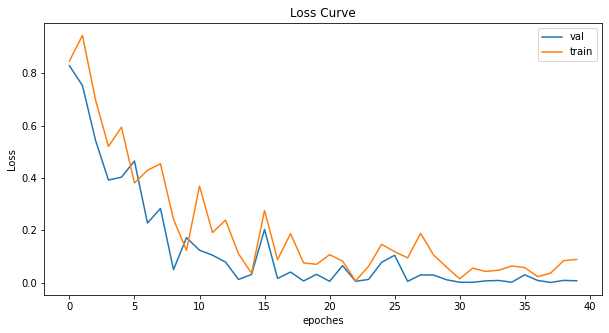

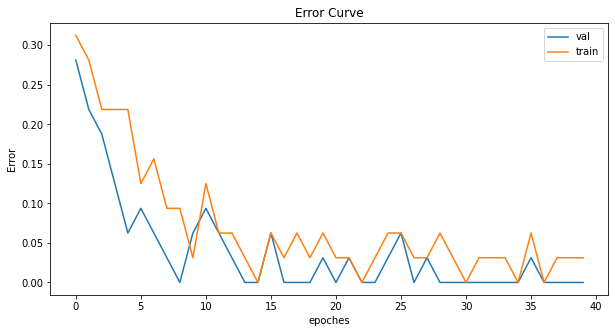

Forget time is: 312.10518431663513


In [ ]:
nm = hiding(cnn_model, loss='ce', optimizer='adam', epochs=40, device=device, dataset=forget, lossfn=None, train_loader=retain, val_loader=retain,
    scheduler=None, weight_decay=0.0, lr=0.01, momentum=0)

In [ ]:
test(model=nm, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar10', test_loader=retain, at_epoch=40, name="")

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[0] test metrics:{"loss": 0.007061602547764778, "error": 0.0}
FINISHED TESTING


Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 1.2537202835083008, "error": 0.0}
[0] test metrics:{"loss": 3.9536924362182617, "error": 1.0}
Epoch number: 0 
Epoch Time: 21.41 sec
[1] train metrics:{"loss": 2.8600761890411377, "error": 0.0}
[1] test metrics:{"loss": 3.9528703689575195, "error": 1.0}
Epoch number: 1 
Epoch Time: 21.33 sec
[2] train metrics:{"loss": 2.980781316757202, "error": 0.0}
[2] test metrics:{"loss": 3.9437975883483887, "error": 1.0}
Epoch number: 2 
Epoch Time: 21.69 sec
[3] train metrics:{"loss": 2.973498821258545, "error": 0.0}
[3] test metrics:{"loss": 3.944194793701172, "error": 1.0}
Epoch number: 3 
Epoch Time: 21.43 sec
[4] train metrics:{"loss": 2.976189136505127, "error": 0.0}
[4] test metrics:{"loss": 3.9441463947296143, "error": 1.0}
Epoch number: 4 
Epoch Time: 21.56 sec
[5] train metrics:{"loss": 2.9757394790649414, "error": 0.0}
[5] test metrics:{"loss": 3.9441745281219482, "error": 1.0}
Epo

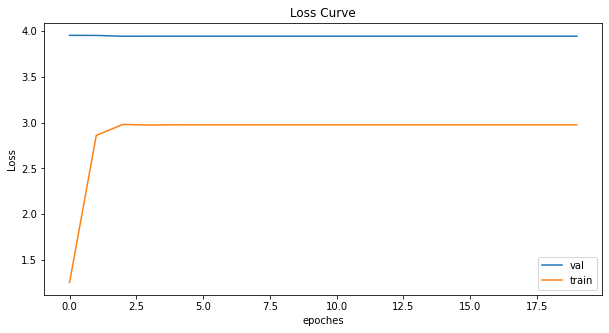

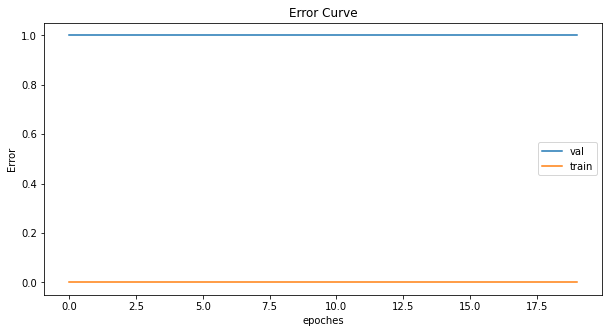

Forget time is: 430.57788467407227


In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{60}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar10', test_loader=cifar10_test, at_epoch=60)
fine_tune(cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset=retain, lossfn=None, train_loader=noisy, val_loader=retain,
    scheduler=None, weight_decay=1.0, lr=0.1, momentum=0.9)

In [ ]:
test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset=forget, test_loader=retain, at_epoch=20)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[0] test metrics:{"loss": 3.9441981315612793, "error": 1.0}
FINISHED TESTING


In [ ]:
random_labels(cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset=forget, lossfn=None, train_loader=retain,
   val_loader=forget, scheduler=None, weight_decay=0.1, lr=0.01, momentum=0.9)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 3.197683334350586, "error": 0.8125}
[0] test metrics:{"loss": 4.831615447998047, "error": 1.0}
Epoch number: 0 :
 Epoch Time: 5.47 sec
[1] train metrics:{"loss": 3.204857349395752, "error": 0.9375}
[1] test metrics:{"loss": 4.962646007537842, "error": 1.0}
Epoch number: 1 :
 Epoch Time: 5.43 sec
[2] train metrics:{"loss": 3.2000699043273926, "error": 0.9375}
[2] test metrics:{"loss": 4.994072914123535, "error": 1.0}
Epoch number: 2 :
 Epoch Time: 5.34 sec
[3] train metrics:{"loss": 3.1898672580718994, "error": 0.9375}
[3] test metrics:{"loss": 5.001162528991699, "error": 1.0}
Epoch number: 3 :
 Epoch Time: 5.44 sec
[4] train metrics:{"loss": 3.1801228523254395, "error": 0.9375}
[4] test metrics:{"loss": 4.999298095703125, "error": 1.0}
Epoch number: 4 :
 Epoch Time: 5.51 sec
[5] train metrics:{"loss": 3.1729676723480225, "error": 0.9375}
[5] test metrics:{"loss": 4.998154640197754

In [ ]:
test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar10', test_loader=forget, at_epoch=20, name="random_lables")

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[0] test metrics:{"loss": 4.990996837615967, "error": 1.0}
FINISHED TESTING


In [16]:
noise = AddNoise(mean=0, std=0.1)
noisy_forget = noise.encode_data(forget)
noisy_retain = noise.encode_data(retain)
#show_random(noisy_retain, 3)

In [13]:
concat = combine_datasets(noisy_forget, noisy_retain)
len(concat)

1563

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  1.4450929164886475
Error:  0.25
FINISHED TESTING
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 1.8243564367294312, "error": 0.5}
[0] test metrics:{"loss": 0.6973388195037842, "error": 0.0}
Epoch number: 0 
Epoch Time: 33.79 sec
[1] train metrics:{"loss": 1.3132846355438232, "error": 0.4375}
[1] test metrics:{"loss": 0.9518823623657227, "error": 1.0}
Epoch number: 1 
Epoch Time: 33.84 sec
[2] train metrics:{"loss": 1.3436304330825806, "error": 0.4375}
[2] test metrics:{"loss": 0.8568827509880066, "error": 1.0}
Epoch number: 2 
Epoch Time: 33.82 sec
FINISHED TRAINING


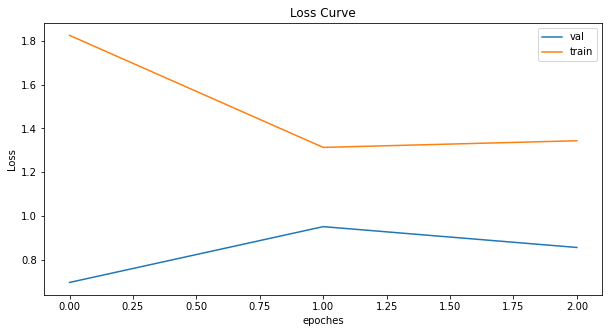

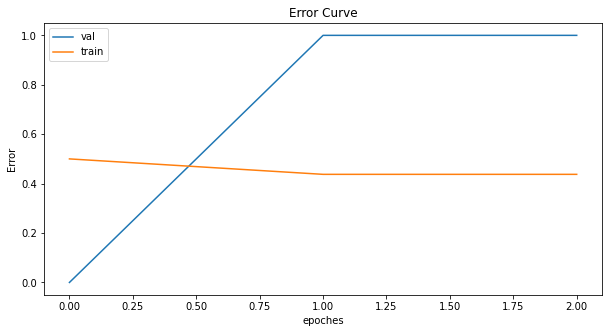

Forget time is: 101.87204933166504


In [19]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{60}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset=retain, test_loader=concat, at_epoch=None)
fine_tune(cnn_model, loss='ce', optimizer='adam', epochs=3, device=device, dataset='cifar', lossfn=None, train_loader=concat, val_loader=retain,
    scheduler=None, weight_decay=0, lr=0.01, momentum=0, name='fine_tune')

In [21]:
test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=forget, at_epoch=3)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
[3] test metrics:{"loss": 8.010148048400879, "error": 1.0}
FINISHED TESTING


CNN(
  (features): Sequential(
    (0): ConvUnit(
      (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvUnit(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvUnit(
      (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Dropout(p=0.5, inplace=True)
    (4): ConvUnit(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (5): ConvUnit(
      (0): Conv2

In [ ]:
checkpoint = torch.load(f"/content/drive/My Drive/project/URP/checkpoints/{cnn_model.__class__.__name__}_{60}.pth.tar")
cnn_model.load_state_dict(checkpoint['model'])
test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=retain, at_epoch=None)
neg_gradient(cnn_model, loss='ce', optimizer='adam', epochs=20, device=device, dataset="cifar", lossfn=None, train_loader=noisy_forget, val_loader=retain,
    scheduler=None, weight_decay=0.0, lr=0.01, momentum=0)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  0.09602899104356766
Error:  0.0
FINISHED TESTING
Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
[Logging in CNN_training]
[0] train metrics:{"loss": 20.649782180786133, "error": 1.0}
[0] test metrics:{"loss": 59.956844329833984, "error": 1.0}
Epoch number: 0 :
 Epoch Time: 0.13 sec
[1] train metrics:{"loss": 8.156062126159668, "error": 1.0}
[1] test metrics:{"loss": 29.409408569335938, "error": 0.8947368413209915}
Epoch number: 1 :
 Epoch Time: 0.13 sec
[2] train metrics:{"loss": 3.9897754192352295, "error": 0.1904761791229248}
[2] test metrics:{"loss": 15.198840141296387, "error": 0.8947368413209915}
Epoch number: 2 :
 Epoch Time: 0.14 sec
[3] train metrics:{"loss": 2.1911768913269043, "error": 0.0476190447807312}
[3] test metrics:{"loss": 13.787266731262207, "error": 0.9473684206604958}
Epoch number: 3 :
 Epoch Time: 0.13 sec
[4] train metrics:{"loss": 1.0118478536605835, "error": 0.0}
[4] test metrics:{"loss

In [ ]:
test(model=cnn_model, loss='ce', lossfn=None, optimizer='adam', device=device, dataset='cifar', test_loader=retain, at_epoch=None)

Optimizer: 	  adam

Loss function:
CrossEntropyLoss()
TESTING
Loss:  7.71566915512085
Error:  0.9473684206604958
FINISHED TESTING


CNN(
  (features): Sequential(
    (0): ConvUnit(
      (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvUnit(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvUnit(
      (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Dropout(p=0.5, inplace=True)
    (4): ConvUnit(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (5): ConvUnit(
      (0): Conv2